# Selecionando Arquivos para Trabalho

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [111]:
# from utils.load_env import load_env
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
# Segregando apenas arquivos rotulados com crises

d1 = pd.read_csv('../docs/ref_eval.txt',sep=' ', header=None)
d2 = pd.read_csv('../docs/ref_train.txt',sep=' ', header=None)
d3 = pd.read_csv('../docs/ref_dev.txt',sep=' ', header=None)


col = ['file','start','end','class','qtd']

d1.columns = col
d2.columns = col
d3.columns = col

d1['dataset'] = np.repeat('eval',len(d1))
d2['dataset'] = np.repeat('train',len(d2))
d3['dataset'] = np.repeat('dev',len(d3))

d = pd.concat([d1,d2,d3])

# Filtrando apenas rótulados com crise
d = d[d['class']!='bckg'].reset_index(drop=True)

d.head()

,file,start,end,class,qtd,dataset
0,00000016_s006_t000,548.9697,593.0707,seiz,1.0,eval
1,00000016_s006_t000,636.0202,708.0505,seiz,1.0,eval
2,00000016_s006_t000,1785.9697,2235.0909,seiz,1.0,eval
3,00000016_s006_t000,2267.6061,2274.0909,seiz,1.0,eval
4,00000314_s012_t002,1.0000,986.0000,seiz,1.0,eval


In [25]:
# Manipulando path's de arquivos

file = pd.read_csv('../json/files_tse.txt',header=None)
file.columns = ['path']

file['file'] = file.apply(lambda row: row[0].split('/')[-1].replace('.tse',''), axis=1)
file['dataset'] = file.apply(lambda row: row[0].split('/')[6], axis=1)

file = file[file['file'].isin(d.file.unique())].reset_index(drop=True)

file.head()

,path,file,dataset
0,/media/davi/6A81-05CF/tuh_eeg_seizure/edf/trai...,00013145_s003_t005,train
1,/media/davi/6A81-05CF/tuh_eeg_seizure/edf/dev/...,00000258_s003_t002,dev
2,/media/davi/6A81-05CF/tuh_eeg_seizure/edf/dev/...,00000258_s003_t003,dev
3,/media/davi/6A81-05CF/tuh_eeg_seizure/edf/dev/...,00000258_s003_t004,dev
4,/media/davi/6A81-05CF/tuh_eeg_seizure/edf/dev/...,00000258_s003_t005,dev


In [28]:
file.groupby('dataset').count()

,path,file
dataset,,
dev,280,280
eval,235,235
train,870,870


In [43]:
def get_types(file):
    name = file.split('/')[-1].replace('.tse','')
    df = pd.read_csv(file,header=None).iloc[1:]
    df.columns = ['path']
    df['type'] = df.apply(lambda row: row[0].split(' ')[-2], axis=1)
    df['start'] = df.apply(lambda row: row[0].split(' ')[0], axis=1)
    df['end'] = df.apply(lambda row: row[0].split(' ')[1], axis=1)
    df['file'] = np.repeat(name, len(df))
    df = df.astype({'start':float,'end':float})
    df = df[df['type']!='bckg'].loc[:,['file','type','start','end']]
    return df.to_dict('records')
   


all_types = []


for index, row in file.iterrows():
    item = row['path']
    result = get_types(item)
    all_types.append(result)

In [45]:
file['seizures'] = all_types

In [53]:
types = [list(pd.DataFrame(item)['type'].unique()) for item in file.seizures]
file['types'] = types

,dataset,types,qtd
0,dev,absz,6
1,dev,cpsz,35
2,dev,fnsz,158
3,dev,gnsz,56
4,dev,mysz,1
5,dev,spsz,3
6,dev,tcsz,17
7,dev,tnsz,19
8,eval,absz,1
9,eval,cpsz,38


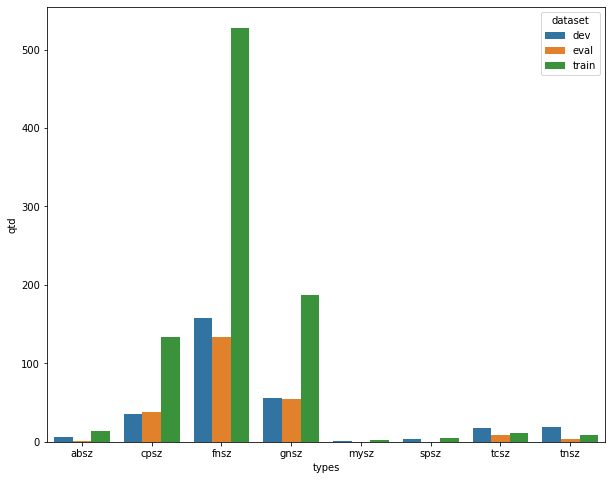

In [113]:
# Contagem de tipso de crise por datasets

g = (file.explode('types')
     .groupby(['dataset','types'])
     .agg(qtd=('types','count')))

g = g.reset_index(level=['dataset', 'types'])


fig = plt.figure(figsize=(10,8))

sns.barplot(data=g,y='qtd',x='types',hue='dataset')

g